### Introduction

#### Installation

The pywapor package depends on several other packages, most of them get installed automatically when we install pywapor. The GDAL package needs to be installed manually however. Luckily, it is already installed on the backend computer used by Google Colab. We can verify that GDAL is installed by running the following commands.

In [1]:
from osgeo import gdal
print("Using gdal version", gdal.__version__)

Using gdal version 3.6.2


Now that we know that Python is able to import the GDAL package, we can install pywapor by running the following command.



In [ ]:
!pip install pywapor --quiet

If everything went well, we can now import pywapor in Python, let's try it (fingers crossed)!

In [2]:
import pywapor
print("Using pywapor version:", pywapor.__version__)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Using pywapor version: 3.3.0


#### ETLook Input

In order to run the ETLook model, we first need to collect the necessary inputs. For your convenience, the pywapor package has a function that can collect all this data from selected sources and make sure the data is stored in the correct format. In one of the following lessons we will look more closely at how you can adjust these inputs. Here we will focus on running a basic configuration.

Because some of the data portals used require a user to login with a username and a password, we first need to set those up. Most importantly, we will need a `NASA Earthdata Login` to be able to collect the MODIS and MERRA2 datasets, which can be created [over here](https://urs.earthdata.nasa.gov/users/new).

> ⚠️
>
> After creating your account, you still need to accept some 'Terms of Use', before you can continue with this notebook. To do that, login to your newly created account and go to
>
> `Applications > Authorized Apps > Approve More Applications`
>
> There, make sure the two following applications are authorized:
> 1. `NASA GESDISC DATA ARCHIVE`
> 2. `LP DAAC OPeNDAP`
>
> ⚠️

Once you have your account set up, we can enter our username and password by running the following code (if you skip this step, you'll be prompted for your username and password once the script starts downloading any product that requires them).


In [3]:
pywapor.collect.accounts.setup("NASA")

Now that we have our account set up we can start defining our period and area-of-interest (AOI). 

First we define a time period through `timelim`, our boundingbox through `latlim` and `lonlim` and we give a `project_folder` in which all our data will be stored. Here I've chosen an period of exactly 10 days which is the default composite length of pyWAPOR. We'll talk more about composites in the next lesson. The given boundingbox will show us the Fayoum irrigation scheme in Egypt.

Note that for `latlim` the first value refers to the southern border of your AOI, so this value should always be smaller than the second. For `lonlim`, the first value refers to the western border of your AOI.

In [3]:
project_folder = r"/Users/hmcoerver/pywapor_notebooks_1"
timelim = ["2021-07-01", "2021-07-11"]
latlim = [28.9, 29.7]
lonlim = [30.2, 31.2]

Then we can run `pywapor.pre_et_look.main()` to start the downloading.

In [4]:
ds  = pywapor.pre_et_look.main(project_folder, latlim, lonlim, timelim)

> PRE_ET_LOOK
    --> Collecting `ndvi` from `MODIS.MOD13Q1.061`.
        --> Applying 'mask_qa' to `ndvi`.              
        --> Saving merged data.
            > peak-memory-usage: 4.6MB, execution-time: 0:00:02.406950.
            > chunksize|dimsize: [time: 2|2, y: 403|403, x: 506|506]
            > timesize: 2 [2021-07-04T00:00, ..., 2021-07-20T00:00]
    --> Collecting `ndvi` from `MODIS.MYD13Q1.061`.
        --> Applying 'mask_qa' to `ndvi`.              
        --> Saving merged data.
            > peak-memory-usage: 2.3MB, execution-time: 0:00:02.046644.
            > chunksize|dimsize: [time: 1|1, y: 403|403, x: 506|506]
            > timesize: 1 [2021-07-12T00:00, ..., 2021-07-12T00:00]
    --> Collecting `r0` from `MODIS.MCD43A3.061`.
        --> Applying 'shortwave_r0' to `r0`.           
        --> Applying 'mask_qa' to `r0`.
        --> Saving merged data.
            > peak-memory-usage: 10.4MB, execution-time: 0:00:02.102645.
            > chunksize|dimsize: [tim

Once you see the output line `< PRE_ET_LOOK`, the code has finished. The function has created a bunch of files in you `project_folder` and returned a variables `ds`. This variable contains a `xarray.Dataset`. XArray is an Python-package that let's you work with large multi-dimensional datasets. We can see the file this dataset is stored in like this.

In [5]:
fh = ds.encoding["source"]
print(fh)

/Users/hmcoerver/pywapor_notebooks_1/et_look_in.nc


As you can see, the dataset is stored inside a file called `et_look_in.nc`, this file contains all the data we need to run the `et_look` model!

We can have a closer look at the contents of the datasets by simply calling `ds` like this.

In [6]:
ds

<xarray.Dataset>
Dimensions:              (x: 506, y: 403, time_bins: 1)
Coordinates:
  * x                    (x) float64 30.2 30.2 30.2 30.21 ... 31.2 31.2 31.2
  * y                    (y) float64 29.7 29.7 29.7 29.69 ... 28.91 28.9 28.9
    spatial_ref          int64 ...
  * time_bins            (time_bins) datetime64[ns] 2021-07-01
Data variables: (12/78)
    ndvi                 (time_bins, y, x) float64 dask.array<chunksize=(1, 403, 506), meta=np.ndarray>
    r0                   (time_bins, y, x) float64 dask.array<chunksize=(1, 403, 506), meta=np.ndarray>
    se_root              (time_bins, y, x) float64 dask.array<chunksize=(1, 403, 506), meta=np.ndarray>
    p_24                 (time_bins, y, x) float64 dask.array<chunksize=(1, 403, 506), meta=np.ndarray>
    z                    (y, x) float64 dask.array<chunksize=(403, 506), meta=np.ndarray>
    ra_24                (time_bins, y, x) float64 dask.array<chunksize=(1, 403, 506), meta=np.ndarray>
    ...                   ...
    o2                   float64 ...
    co2_ref              int64 ...
    gcgdm                float64 ...
    phot_eff             float64 ...
    r0_bare              float64 ...
    r0_full              float64 ...

The output of calling `ds` is interactive. It contains several parts, at the top you'll see `Dimensions`, which gives information about the dimensions of our dataset. In the W-E (or `x`) direction, the dataset contains 523 values, while in the S-N (`y`) direction 418, i.e. we have 523 * 418 = 218,614 pixels! Finally, there is an `time_bins`-dimension, which is of size 1. Remember that we selected a period of 10 days, `pre_et_look` created 1 composite for that period, hence the size of 1 (we'll talk more about this in a next lesson).

Then there is a part called `Data variables`, you might have to click on it to expand its information. Once you do that, you'll see a list of variables for which the data is stored inside the file specified by `fh`. After each variable name, you can see it's dimensions. E.g. `ndvi` is a 3-dimensional variable, while `z` is 2-dimensional. To get more information about a variable, you can click on the little 'paper'-icon at the end of the line. If you look at the info for `ndvi` for example, you should see that `ndvi` stands for "Normalized difference vegetation index" and its unit is \[-\].

Finally, just like geotiff files, this dataset also contains information like it's coordinate reference system and boundaries. We can access that information like this.

In [7]:
print(ds.rio.crs)
print(ds.rio.bounds())
print(ds.rio.resolution())

EPSG:4326
(30.198124670407314, 28.90197637470393, 31.201417564659167, 29.70104166399938)
(0.001982792281130139, -0.001982792281130138)


XArray datasets are also easy to plot, for example, we can create a map of `z` like this (Note that XArray is smart enough to automatically fill in the units and the description of the variable!).

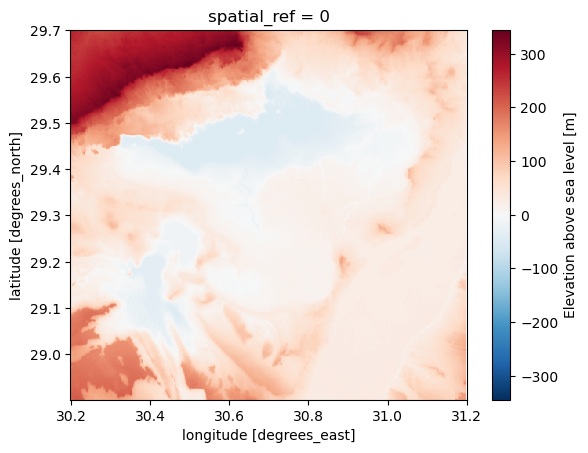

In [8]:
ds.z.plot()

If we want to make a map of a 3-dimensional variable, we'll have to select for which time (i.e. `time_bins`) we want to create the map. Here I'm selecting the first map, i.e. at index 0.

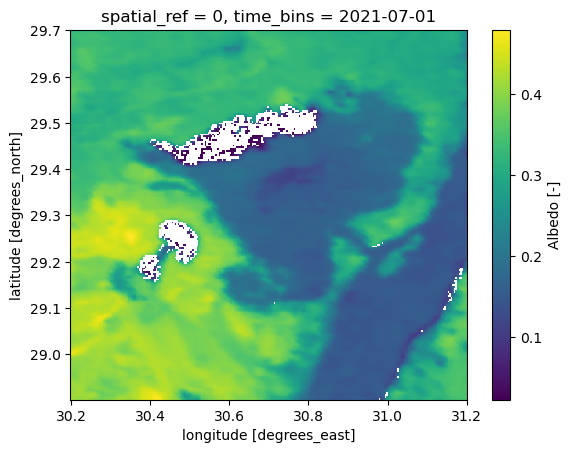

In [9]:
ds.r0.isel(time_bins = 0).plot()

If for some reason you have lost the variable `ds` (maybe you restarted you computer) and don't want to run `pre_et_look` again, you can simply open the file specified by `fh` like this. (The `decode_coords` keyword is used to make sure the CRS information is loaded correctly.)

In [10]:
import xarray as xr
ds = xr.open_dataset(fh, decode_coords = "all")

#### Running ETLook

Now that we have created the input file for the model, we can run the model! We simply pass the `ds` to `pywapor.et_look.main()`.

In [11]:
ds_out = pywapor.et_look.main(ds)

> ET_LOOK
    --> Running `et_look` (v2).
    --> Calculating `declination`.
    --> Calculating `inverse_earth_sun_distance`.
    --> Calculating `vegetation_cover`.
    --> Calculating `leaf_area_index`.
    --> Calculating `effective_leaf_area_index`.
    --> Calculating `soil_fraction`.
    --> Calculating `latitude_rad`.
    --> Calculating `sunset_hour_angle`.
    --> Calculating `daily_solar_radiation_toa_flat`.
    --> Calculating `transmissivity`.
    --> Calculating `stress_radiation`.
    --> Calculating `air_pressure_kpa2mbar`.
    --> Calculating `air_pressure_daily`.
    --> Calculating `air_pressure`.
    --> Calculating `vapour_pressure_from_specific_humidity_daily`.
    --> Calculating `vapour_pressure_from_specific_humidity`.
    --> Calculating `saturated_vapour_pressure`.
    --> Calculating `vapour_pressure_deficit_daily`.
    --> Calculating `vapour_pressure_deficit`.
    --> Calculating `stress_vpd`.
    --> Calculating `stress_temperature`.
    --> Calculating `

This should go pretty quickly (a couple of seconds). Again, we can see a new netCDF file has been created.

In [12]:
fh_out = ds_out.encoding["source"]
print(fh_out)

/Users/hmcoerver/pywapor_notebooks_1/et_look_out.nc


And we can check the contents of the new dataset just like we did before.

In [13]:
ds_out

<xarray.Dataset>
Dimensions:       (time_bins: 1, y: 403, x: 506)
Coordinates:
  * x             (x) float64 30.2 30.2 30.2 30.21 ... 31.19 31.2 31.2 31.2
  * y             (y) float64 29.7 29.7 29.7 29.69 ... 28.91 28.91 28.9 28.9
    spatial_ref   int64 ...
  * time_bins     (time_bins) datetime64[ns] 2021-07-01
Data variables:
    int_mm        (time_bins, y, x) float64 dask.array<chunksize=(1, 403, 506), meta=np.ndarray>
    t_24_mm       (time_bins, y, x) float64 dask.array<chunksize=(1, 403, 506), meta=np.ndarray>
    e_24_mm       (time_bins, y, x) float64 dask.array<chunksize=(1, 403, 506), meta=np.ndarray>
    et_24_mm      (time_bins, y, x) float64 dask.array<chunksize=(1, 403, 506), meta=np.ndarray>
    et_ref_24_mm  (time_bins, y, x) float64 dask.array<chunksize=(1, 403, 506), meta=np.ndarray>
    se_root       (time_bins, y, x) float64 dask.array<chunksize=(1, 403, 506), meta=np.ndarray>
    npp           (time_bins, y, x) float64 dask.array<chunksize=(1, 403, 506), meta=np.ndarray>

As you can see, the `Dimensions` and `Attributes` parts are the same. The `Data variables` however, now contain our output variables. We can plot them in the same way as we did with the input dataset.

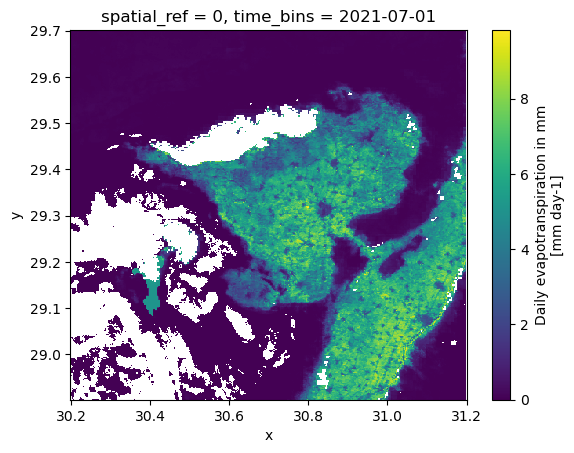

In [14]:
ds_out.et_24_mm.isel(time_bins = 0).plot()

If you want to do some calulcations with the data, you can get easily get a numpy-array (e.g. for `et_24_mm`). Note that this loads the array into you working memory.

In [15]:
import numpy as np

et_data = ds_out.et_24_mm.isel(time_bins = 0).values

print("resolution:", et_data.shape)
print("total pixels:", et_data.size)
print("number of pixels with missing data:", np.sum(np.isnan(et_data)))
print("maximum value: {0:.2f}".format(np.nanmax(et_data)))
print("minimum value: {0:.2f}".format(np.nanmin(et_data)))
print("mean: {0:.2f}".format(np.nanmean(et_data)))
print("median: {0:.2f}".format(np.nanmedian(et_data)))

resolution: (403, 506)
total pixels: 203918
number of pixels with missing data: 32916
maximum value: 9.82
minimum value: 0.00
mean: 1.96
median: 0.10


As we could see, the output dataset only contained 6 variables. If you'd want to output all the variables that ET_Look calculated however, you could run `pywapor.et_look.main` like this.

In [16]:
ds_out_all = pywapor.et_look.main(fh, export_vars = "all")

> ET_LOOK
    --> Running `et_look` (v2).
    --> Calculating `declination`.
    --> Calculating `inverse_earth_sun_distance`.
    --> Calculating `vegetation_cover`.
    --> Calculating `leaf_area_index`.
    --> Calculating `effective_leaf_area_index`.
    --> Calculating `soil_fraction`.
    --> Calculating `latitude_rad`.
    --> Calculating `sunset_hour_angle`.
    --> Calculating `daily_solar_radiation_toa_flat`.
    --> Calculating `transmissivity`.
    --> Calculating `stress_radiation`.
    --> Calculating `air_pressure_kpa2mbar`.
    --> Calculating `air_pressure_daily`.
    --> Calculating `air_pressure`.
    --> Calculating `vapour_pressure_from_specific_humidity_daily`.
    --> Calculating `vapour_pressure_from_specific_humidity`.
    --> Calculating `saturated_vapour_pressure`.
    --> Calculating `vapour_pressure_deficit_daily`.
    --> Calculating `vapour_pressure_deficit`.
    --> Calculating `stress_vpd`.
    --> Calculating `stress_temperature`.
    --> Calculating `

Now `ds_out_all` contains all the variables calculated by ET_Look.

In [17]:
list(ds_out_all.data_vars)

['ndvi',
 'r0',
 'se_root',
 'p_24',
 'z',
 'ra_24',
 't_air_24',
 't_air_max_24',
 't_air_min_24',
 'u2m_24',
 'v2m_24',
 'qv_24',
 'p_air_24',
 'p_air_0_24',
 'wv_24',
 'land_mask',
 'rs_min',
 'z_obst_max',
 'lw_offset',
 'lw_slope',
 'z_oro',
 'rn_offset',
 'rn_slope',
 't_amp_year',
 't_opt',
 'vpd_slope',
 't_diff',
 'doy',
 'nd_min',
 'nd_max',
 'vc_pow',
 'vc_min',
 'vc_max',
 'lai_pow',
 'diffusion_slope',
 'diffusion_intercept',
 't_min',
 't_max',
 'vp_slope',
 'vp_offset',
 'int_max',
 'tenacity',
 'rcan_max',
 'ndvi_obs_min',
 'ndvi_obs_max',
 'obs_fr',
 'z_obs',
 'z_b',
 'c1',
 'iter_h',
 'r_soil_pow',
 'r_soil_min',
 'se_top',
 'porosity',
 'r0_grass',
 'eps_a',
 'z0m_full',
 'z0m_bare',
 'aod550_i',
 'fraction_h_bare',
 'fraction_h_full',
 'disp_bare',
 'disp_full',
 'r0_bare_wet',
 'IO',
 'dh_ap',
 'd_s',
 'dh_dp',
 'ar_slo',
 'ar_int',
 'fpar_slope',
 'fpar_offset',
 'o2',
 'co2_ref',
 'gcgdm',
 'phot_eff',
 'r0_bare',
 'r0_full',
 'ad_24',
 'ad_dry_24',
 'ad_moist_24